In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [9]:
with open('../python/methods.py', 'r') as file:
    exec(file.read())

with open('../python/methods_for_r.py', 'r') as file:
    exec(file.read())

In [11]:
samples = pd.read_csv('../sample_sheet.csv')
samples = samples[samples['Region'] == 'M1_L23']
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location
20,W1_C3,W1,C3,M1_L23,2019 12 09,305.290403,310,W1/C3
21,W1_C4,W1,C4,M1_L23,2019 12 09,374.226946,380,W1/C4
22,W1_C5,W1,C5,M1_L23,2019 12 09,216.657706,220,W1/C5
23,W1_C6,W1,C6,M1_L23,2019 12 09,305.290403,310,W1/C6
24,W2_C1,W2,C1,M1_L23,2019 12 12,142.797124,145,W2/C1
25,W2_C2,W2,C2,M1_L23,2019 12 12,315.138481,320,W2/C2
26,W3_C1,W3,C1,M1_L23,2019 12 17,374.226946,380,W3/C1
27,W3_C2,W3,C2,M1_L23,2019 12 17,157.569240,160,W3/C2
28,W3_C3,W3,C3,M1_L23,2019 12 17,384.075024,390,W3/C3
29,W3_C7,W3,C7,M1_L23,2019 12 17,315.138481,320,W3/C7


In [15]:
def read_sample_event_start(sample_name, start_offset = 0, end_offset = 0.25, data_type = 'vm'):
    import re
    import numpy as np

    animal_id = re.match('(W[0-9]+).*', sample_name).group(1)
    cell_name = re.match('.*(C[0-9]+)', sample_name).group(1)

    prefix = f'../output/spontaneous-movement/{animal_id}/{cell_name}'
    
    if data_type == 'vm':
        sample_data = read_pickle(f'{prefix}/vm/filter.pkl')
    else:
        sample_data = read_pickle(f'{prefix}/emg/filter.pkl')

    sample_events = read_pickle(f'{prefix}/emg/filtered_movement_events.pkl')

    n_expected_points = sample_data.info['sfreq'] * np.abs(start_offset - end_offset) + 1

    event_data = []
    for i, event in sample_events.iterrows():
        start = event['Start'] + start_offset
        start = np.max([start, np.min(sample_data.times)])
        end = event['Start'] + end_offset
        end = np.min([end, np.max(sample_data.times)])

        channel = event['ChannelId']

        channel_data = sample_data.copy().crop(tmin = start, tmax = end).get_data(picks = [channel]).flatten()

        # If the time shift was not possible, will have to append a few points here and there
        if len(channel_data) < n_expected_points:
            average = np.mean(channel_data)
            append = np.ones(int(n_expected_points - len(channel_data)))
            append = append * average

            assert len(append) + len(channel_data) == n_expected_points

            print('Event was too short, appending at the end')
            channel_data = np.concatenate([channel_data, append])

        event_data.append(channel_data)

    event_data = np.array(event_data)

    return event_data

In [16]:
def read_event_data(sample_ids, start_offset = 0, end_offset = 0.25, data_type = 'vm'):
    import numpy as np

    event_data = []
    for sample_id in sample_ids:
        event_data.append(
            read_sample_event_start(
                sample_id,
                start_offset = start_offset,
                end_offset = end_offset,
                data_type = data_type
            ))

    event_data = np.concatenate(event_data)
    return event_data

In [17]:
baseline = read_event_data(sample_ids = samples['SID'], start_offset = -0.400, end_offset = -0.200)
pre_movement = read_event_data(sample_ids = samples['SID'], start_offset = -0.100, end_offset = -0)
movement_onset = read_event_data(sample_ids = samples['SID'], start_offset = 0, end_offset = 0.100)
late_movement = read_event_data(sample_ids = samples['SID'], start_offset = 0.200, end_offset = 0.400)
full = read_event_data(sample_ids = samples['SID'], start_offset = -0.400, end_offset = 0.400)

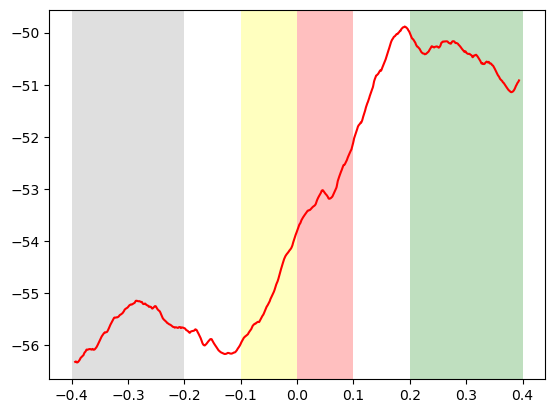

In [18]:
y = np.mean(full, axis = 0)
window_size = 250
crop_size = int(window_size / 2) + 1
y = np.convolve(y, np.ones(window_size) / window_size, mode = 'same')[ crop_size :-crop_size ]

sfreq = 20_000  # Hz
x = np.array(range(int(-0.400 * sfreq), int(0.400 * sfreq) + 1, 1)) / 20_000
x = x[ crop_size:-crop_size ]

plt.axvspan(-0.4, -0.2, facecolor = 'gray', alpha = 0.25)
plt.axvspan(-0.1, 0, facecolor = 'yellow', alpha = 0.25)
plt.axvspan(0, 0.1, facecolor = 'red', alpha = 0.25)
plt.axvspan(0.2, 0.4, facecolor = 'green', alpha = 0.25)
plt.plot(x, y, c = 'red')
plt.show()

In [19]:
dt = np.concatenate([
    np.mean(baseline, axis = 1),
    np.mean(pre_movement, axis = 1),
    np.mean(movement_onset, axis = 1),
    np.mean(late_movement, axis = 1)
])

types = np.concatenate([
    np.repeat('Baseline', baseline.shape[0]),
    np.repeat('Pre-movement', pre_movement.shape[0]),
    np.repeat('Movement onset', movement_onset.shape[0]),
    np.repeat('Late movement', late_movement.shape[0])
])

assert len(dt) == len(types)

dt = pd.DataFrame({
    'Value': dt,
    'Type': types
})

vals = dt['Value'].values
dt['Value'] = (vals - np.mean(vals)) / np.std(vals)

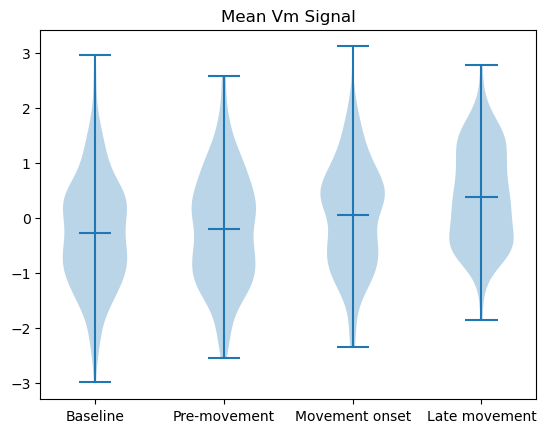

In [20]:
plt.violinplot([
    dt[dt['Type'] == 'Baseline']['Value'],
    dt[dt['Type'] == 'Pre-movement']['Value'],
    dt[dt['Type'] == 'Movement onset']['Value'],
    dt[dt['Type'] == 'Late movement']['Value']
], showmeans = True)

plt.xticks([1, 2, 3, 4], ['Baseline', 'Pre-movement', 'Movement onset', 'Late movement'])
plt.title('Mean Vm Signal')
plt.show()

In [21]:
dt1 = dt[dt['Type'] == 'Baseline']['Value']
dt2 = dt[dt['Type'] == 'Pre-movement']['Value']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('Baseline vs pre-movement')
print('T-statistic:', t_statistic)
print('P-value:', p_value)
print()

dt1 = dt[dt['Type'] == 'Pre-movement']['Value']
dt2 = dt[dt['Type'] == 'Movement onset']['Value']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('Pre-movement vs movement onset')
print('T-statistic:', t_statistic)
print('P-value:', p_value)
print()

dt1 = dt[dt['Type'] == 'Baseline']['Value']
dt2 = dt[dt['Type'] == 'Movement onset']['Value']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('Baseline vs movement onset')
print('T-statistic:', t_statistic)
print('P-value:', p_value)
print()

dt1 = dt[dt['Type'] == 'Movement onset']['Value']
dt2 = dt[dt['Type'] == 'Late movement']['Value']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('Movement onset vs late movement')
print('T-statistic:', t_statistic)
print('P-value:', p_value)

Baseline vs pre-movement
T-statistic: -0.8815152374148305
P-value: 0.3784092705159645

Pre-movement vs movement onset
T-statistic: -3.0770874524792746
P-value: 0.0021903548799094936

Baseline vs movement onset
T-statistic: -4.010675540703921
P-value: 6.857857566418111e-05

Movement onset vs late movement
T-statistic: -4.259172198338776
P-value: 2.3986631966567524e-05


## AP frequency

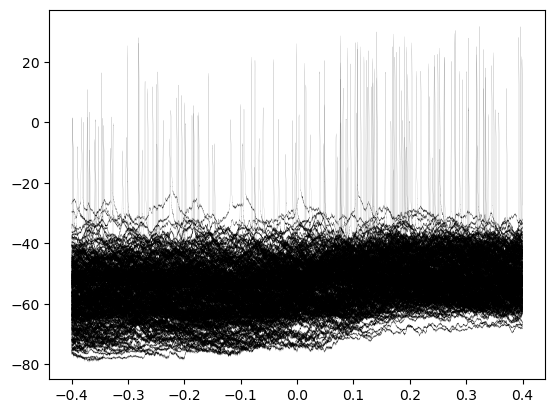

In [22]:
sfreq = 20_000  # Hz
time = np.array(range(int(-0.400 * sfreq), int(0.400 * sfreq) + 1, 1)) / 20_000

for i in full:
    plt.plot(time, i, linewidth = 0.05, color = 'black')

plt.show()

In [23]:
def find_ap(signal, time, ap_threshold = -10):
    over_threshold = np.where(signal > ap_threshold)[0]

    if len(over_threshold) == 0:
        return []

    idx_diff = np.where(np.diff(over_threshold) != 1)[0]
    ap_count = np.append(over_threshold[0], over_threshold[idx_diff + 1])
    
    return time[ap_count]

In [24]:
ap_threshold = -20
aps = []
for index, signal in enumerate(full):
    signal_ap = find_ap(signal, time, ap_threshold = ap_threshold)
    aps.append(pd.DataFrame({
        'Trial': index,
        'Time': signal_ap
    }))

aps = pd.concat(aps)

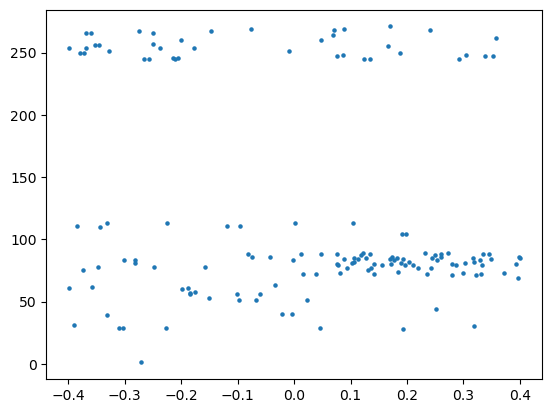

In [25]:
plt.scatter(aps['Time'], aps['Trial'], s = 5)
plt.show()

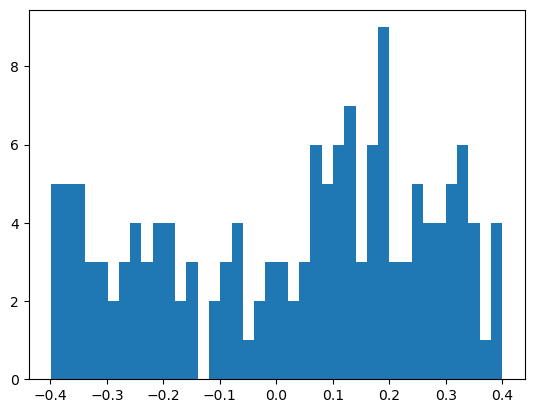

In [26]:
plt.hist(aps['Time'], bins = 40)
plt.show()